In [1]:
import os
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import numpy as np
import arff
from sensitivity_tools import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

## Data and Hyperparameters

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
gen = np.random.RandomState(0)
device = torch.device('cuda:1')

num_positive_samples = [20, 50, 100, 150, 180]
total_samples = 200
test_size = 0.1

neuron_addition_factors = [0.2, 0.35, 0.5]
margin_value_factors = [0.05, 0.15, 0.3]
learning_rates = [1e-4, 5e-4, 1e-3]

plot_styles = ['k^--', 'ks-', 'ko--']

axis_vals = [10, 25, 50, 75, 90]
axis_labels = [r'$10%$', r'$25%$', r'$50%$', r'$75%$', r'$90%$']
neuron_addition_legends = [r'$\alpha_a = ${:.2f}'.format(k) for k in neuron_addition_factors] 
margin_factor_legends = [r'$\alpha_m = ${:.2f}'.format(k) for k in margin_value_factors]
learning_rate_legends = [r'$\eta = ${:.2e}'.format(k) for k in learning_rates]

alpha_a = 0.42
alpha_m = 0.07
lr = 1e-4

alpha_a_label = r'$\alpha_a = {:.2f}$ '.format(alpha_a)
alpha_m_label = r'$\alpha_m = {:.2f}$ '.format(alpha_m)
lr_label = r'$\eta = {:.2e}$ '.format(lr)

In [3]:
def create_data(num_pos, num_neg, test_size, device):
    X, y = make_moons((num_pos, num_neg), random_state=gen)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=gen)

    a, b = X_train.max(axis=0), X_train.min(0)
    train_spikes = encoding(X_train, device, a, b)
    test_spikes = encoding(X_test, device, a, b)
    train_labels = y_train.reshape((-1, 1))
    test_labels = y_test.reshape((-1, 1))

    return train_spikes, test_spikes, train_labels, test_labels

In [4]:
hparams_dict = {
    'name': 'synthetic_moons',
    'inputs': 12,
    'outputs': 1,
    'time_constant': 300,
    'alpha_a': 0.42,
    'alpha_m': 0.07,
    'w_max': 100.0,
    'w_min': -100.0,
    'lr': 5e-4,
    'sim_time': 600,
    'n_epochs': 10,
    'print_every': 200,
    'seed': 2,
    'ckpt_dir': './checkpoints/moons',
    'load_from_file': None,
    'device': device
}

In [5]:
def dict_max_min(data_dict):
    vals = []
    for k, v in data_dict.items():
        vals.append(v)
    vals = np.array(vals)
    return np.max(vals)

def dict_min_max(data_dict):
    vals = []
    for k, v in data_dict.items():
        vals.append(v)
    vals = np.array(vals)
    return np.min(vals)

def plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    yticks = [0.0, 0.25, 0.50, 0.75, 1.0]
    yvals = [str(int(k*dict_max_min(pos_neuron_dict))) for k in yticks]
    ytitle = '# Interneurons'
    xtitle = '% of class 0 samples'

    for i, (k, v) in enumerate(pos_neuron_dict.items()):
        style = plot_styles[i]
        axs[0].plot(axis_vals, v, style, linewidth=2, label = fig_title + k, markersize=12)

    axs[0].set_xticks(axis_vals)
    axs[0].set_xticklabels(axis_labels, fontsize=16, rotation=90)
    axs[0].set_yticks(yticks, yvals)
    axs[0].set_ylabel(ytitle, fontsize=16)
    axs[0].set_xlabel(xtitle, fontsize=16)
    axs[0].set_title('$S^+$ Interneurons', fontsize=18)

    yvals = [str(int(k*dict_max_min(neg_neuron_dict))) for k in yticks]

    for i, (k, v) in enumerate(neg_neuron_dict.items()):
        style = plot_styles[i]
        axs[1].plot(axis_vals, v, style, linewidth=2, label = fig_title + k, markersize=12)

    axs[1].set_xticks(axis_vals)
    axs[1].set_xticklabels(axis_labels, fontsize=16, rotation=90)
    axs[1].set_yticks(yticks, yvals)
    axs[1].set_ylabel(ytitle, fontsize=16)
    axs[1].set_xlabel(xtitle, fontsize=16)
    axs[1].set_title('$S^-$ Interneurons', fontsize=18)

    # yvals = [str(int(k*dict_max_min(spk_diff_dict))) for k in yticks]
    #  min to max
    max_time = dict_max_min(spk_diff_dict)
    min_time = dict_min_max(spk_diff_dict)
    yticks_ = list(np.linspace(min_time, max_time, 5))
    yvals = ['{:.2f}'.format(t) for t in yticks_]
    ytitle = 'Spike Margin'

    for i, (k, v) in enumerate(spk_diff_dict.items()):
        style = plot_styles[i]
        axs[2].plot(axis_vals, v, style, linewidth=2, label = fig_title + k, markersize=12)

    axs[2].set_xticks(axis_vals)
    axs[2].set_xticklabels(axis_labels, fontsize=16, rotation=90)
    axs[2].set_yticks(yticks_, yvals)
    axs[2].set_ylabel(ytitle, fontsize=16)
    axs[2].set_xlabel(xtitle, fontsize=16)
    axs[2].set_title('Spike Time Difference', fontsize=18)

    yvals = [str(int(k*(dict_max_min(acc_dict)))) for k in yticks]
    ytitle = 'Accuracy on smaller class'

    for i, (k, v) in enumerate(acc_dict.items()):
        style = plot_styles[i]
        axs[3].plot(axis_vals, v, style, linewidth=2, label = fig_title + k, markersize=12)

    axs[3].set_xticks(axis_vals)
    axs[3].set_xticklabels(axis_labels, fontsize=16, rotation=90)
    axs[3].set_yticks(yticks, yvals)
    axs[3].set_ylabel(ytitle, fontsize=16)
    axs[3].set_xlabel(xtitle, fontsize=16)
    axs[3].set_title('Accuracy', fontsize=18)

    # handles, labels = axs[3].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', fontsize=16)

    # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc='lower center', ncol=len(pos_neuron_dict.keys()), fontsize=16)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.1), fontsize=16)

    # plt.suptitle(fig_title, fontsize=20)
    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.show()
    return

## Neuron Addition Experiments

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

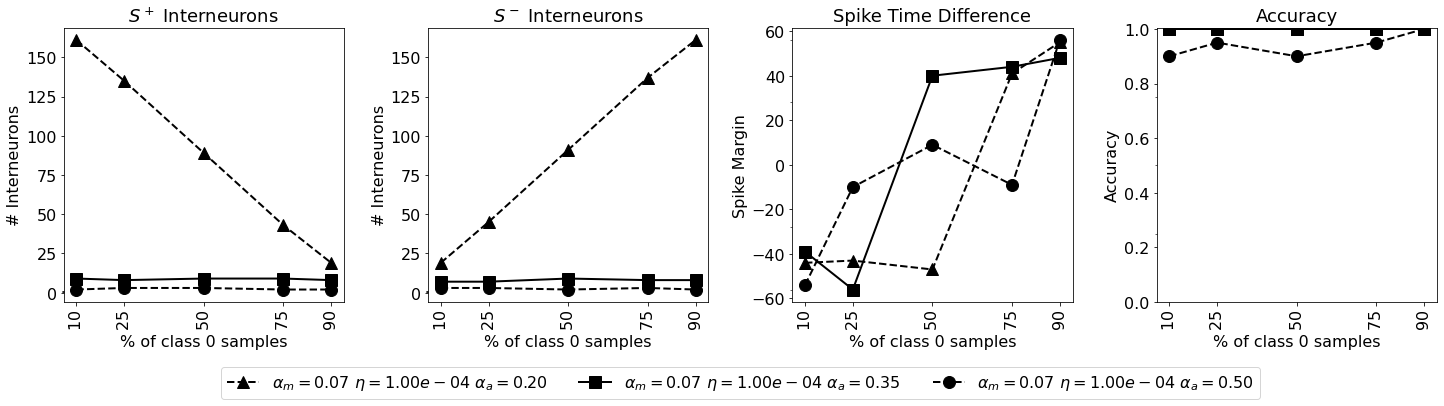

In [6]:
pos_neuron_dict = {k: [] for k in neuron_addition_legends}
neg_neuron_dict = {k: [] for k in neuron_addition_legends}
spk_diff_dict = {k: [] for k in neuron_addition_legends}
acc_dict = {k: [] for k in neuron_addition_legends}

hparams_dict['alpha_m'] = alpha_m
hparams_dict['lr'] = lr

fig_title = alpha_m_label + lr_label

for k, alpha_A in zip(neuron_addition_legends, neuron_addition_factors):
    hparams_dict['alpha_a'] = alpha_A
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Margin Threshold Experiments

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

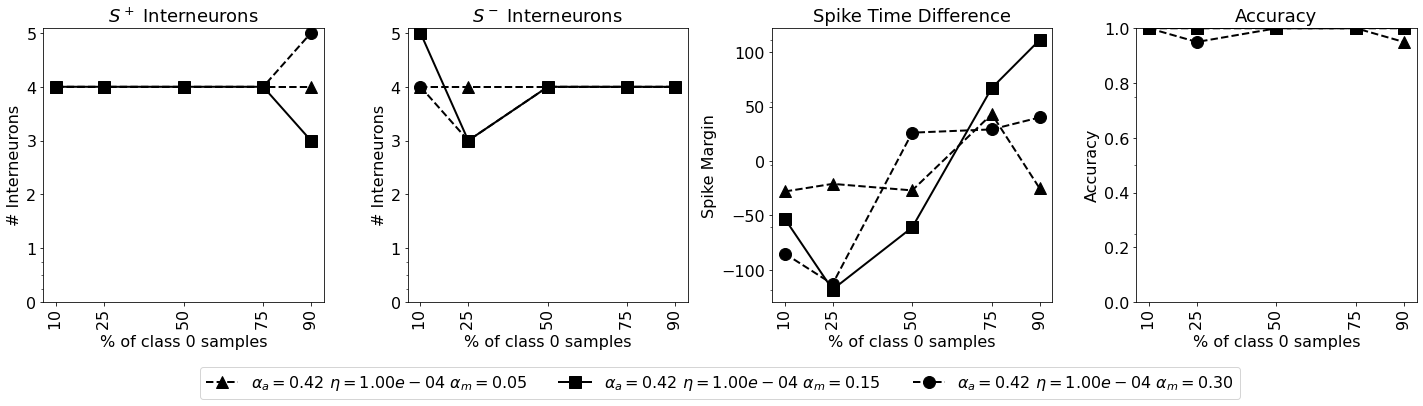

In [7]:
pos_neuron_dict = {k: [] for k in margin_factor_legends}
neg_neuron_dict = {k: [] for k in margin_factor_legends}
spk_diff_dict = {k: [] for k in margin_factor_legends}
acc_dict = {k: [] for k in margin_factor_legends}

hparams_dict['alpha_a'] = alpha_a
hparams_dict['lr'] = lr

fig_title = alpha_a_label + lr_label

for k, alpha_M in zip(margin_factor_legends, margin_value_factors):
    hparams_dict['alpha_m'] = alpha_M
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Learning Rate Experiments

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

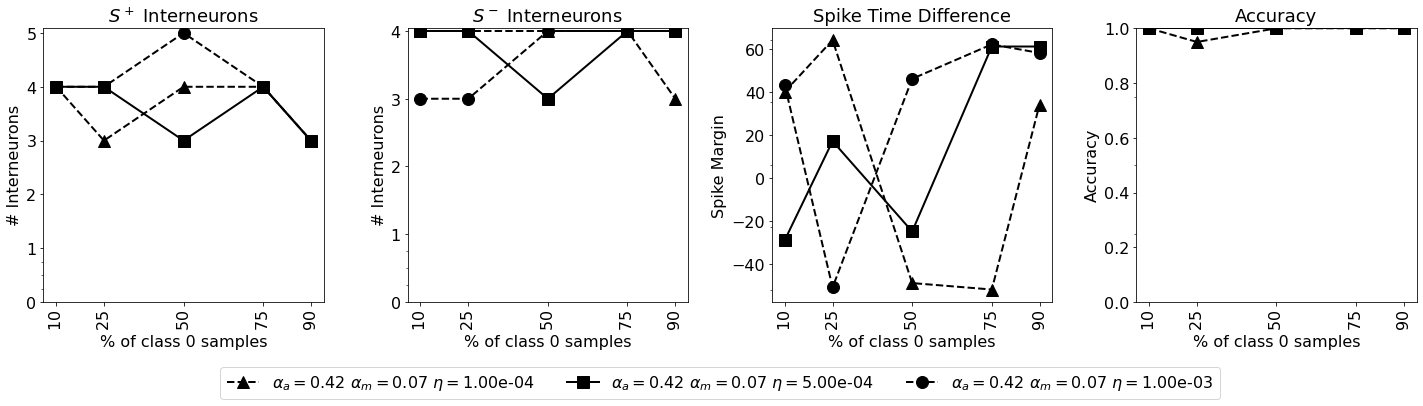

In [8]:
pos_neuron_dict = {k: [] for k in learning_rate_legends}
neg_neuron_dict = {k: [] for k in learning_rate_legends}
spk_diff_dict = {k: [] for k in learning_rate_legends}
acc_dict = {k: [] for k in learning_rate_legends}

hparams_dict['alpha_a'] = alpha_a
hparams_dict['alpha_m'] = alpha_m

fig_title = alpha_a_label + alpha_m_label

for k, LR in zip(learning_rate_legends, learning_rates):
    hparams_dict['lr'] = LR
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Neuron Addition Experiments

100%|██████████| 10/10 [00:02<00:00,  4.66it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

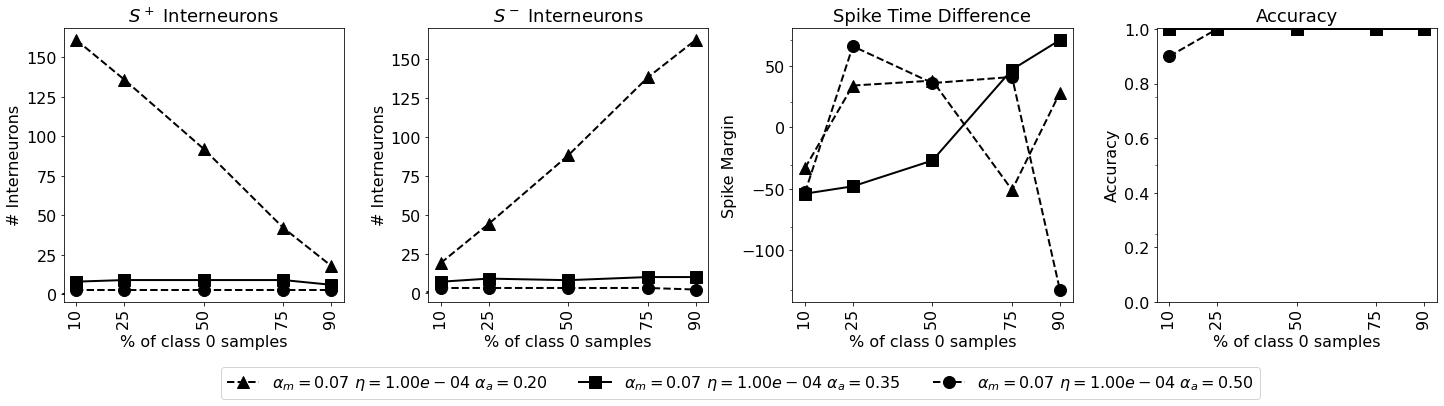

In [9]:
pos_neuron_dict = {k: [] for k in neuron_addition_legends}
neg_neuron_dict = {k: [] for k in neuron_addition_legends}
spk_diff_dict = {k: [] for k in neuron_addition_legends}
acc_dict = {k: [] for k in neuron_addition_legends}

hparams_dict['alpha_m'] = alpha_m
hparams_dict['lr'] = lr

fig_title = alpha_m_label + lr_label

for k, alpha_A in zip(neuron_addition_legends, neuron_addition_factors):
    hparams_dict['alpha_a'] = alpha_A
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Margin Threshold Experiments

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

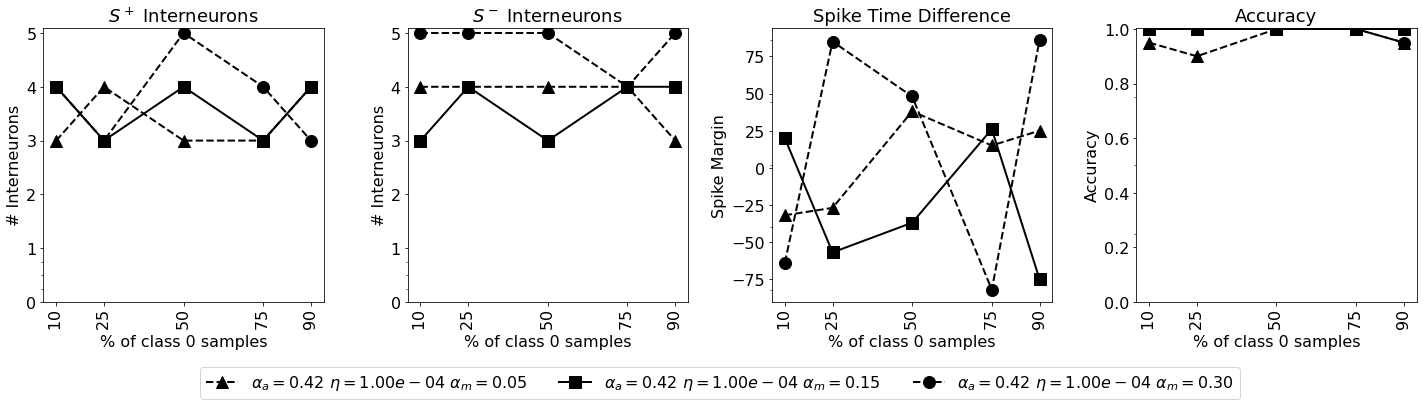

In [10]:
pos_neuron_dict = {k: [] for k in margin_factor_legends}
neg_neuron_dict = {k: [] for k in margin_factor_legends}
spk_diff_dict = {k: [] for k in margin_factor_legends}
acc_dict = {k: [] for k in margin_factor_legends}

hparams_dict['alpha_a'] = alpha_a
hparams_dict['lr'] = lr

fig_title = alpha_a_label + lr_label

for k, alpha_M in zip(margin_factor_legends, margin_value_factors):
    hparams_dict['alpha_m'] = alpha_M
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Learning Rate Experiments

100%|██████████| 10/10 [00:02<00:00,  4.24it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

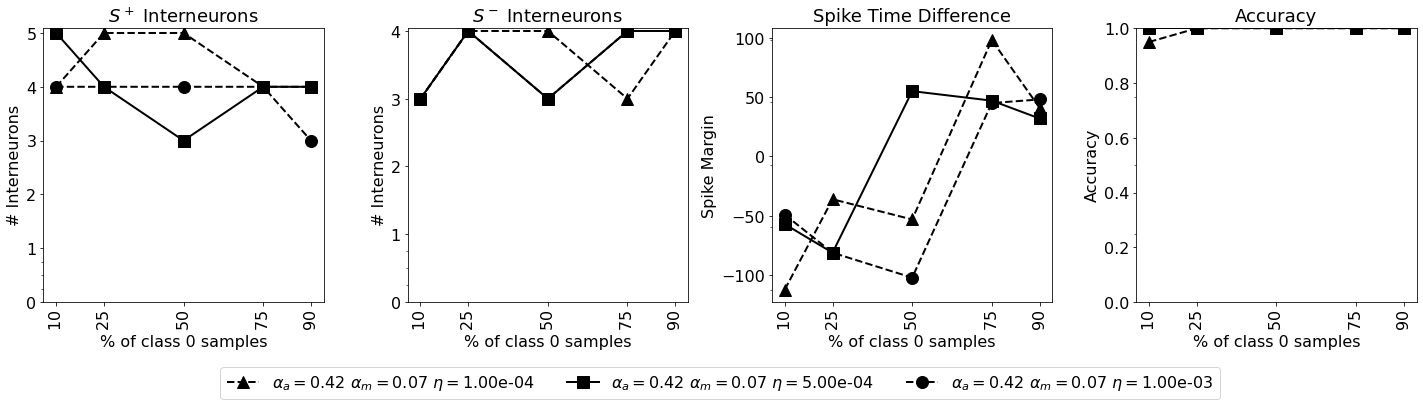

In [11]:
pos_neuron_dict = {k: [] for k in learning_rate_legends}
neg_neuron_dict = {k: [] for k in learning_rate_legends}
spk_diff_dict = {k: [] for k in learning_rate_legends}
acc_dict = {k: [] for k in learning_rate_legends}

hparams_dict['alpha_a'] = alpha_a
hparams_dict['alpha_m'] = alpha_m

fig_title = alpha_a_label + alpha_m_label

for k, LR in zip(learning_rate_legends, learning_rates):
    hparams_dict['lr'] = LR
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Neuron Addition Experiments

100%|██████████| 10/10 [00:02<00:00,  4.80it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

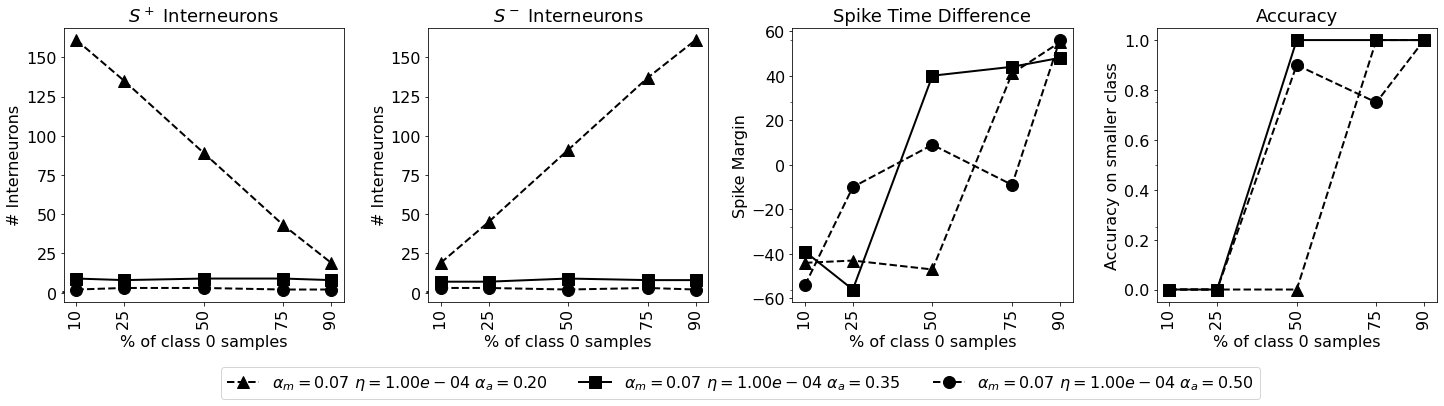

In [6]:
pos_neuron_dict = {k: [] for k in neuron_addition_legends}
neg_neuron_dict = {k: [] for k in neuron_addition_legends}
spk_diff_dict = {k: [] for k in neuron_addition_legends}
acc_dict = {k: [] for k in neuron_addition_legends}

hparams_dict['alpha_m'] = alpha_m
hparams_dict['lr'] = lr

fig_title = alpha_m_label + lr_label

for k, alpha_A in zip(neuron_addition_legends, neuron_addition_factors):
    hparams_dict['alpha_a'] = alpha_A
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)

## Margin Threshold Experiments

100%|██████████| 10/10 [00:03<00:00,  3.25it/s]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWa

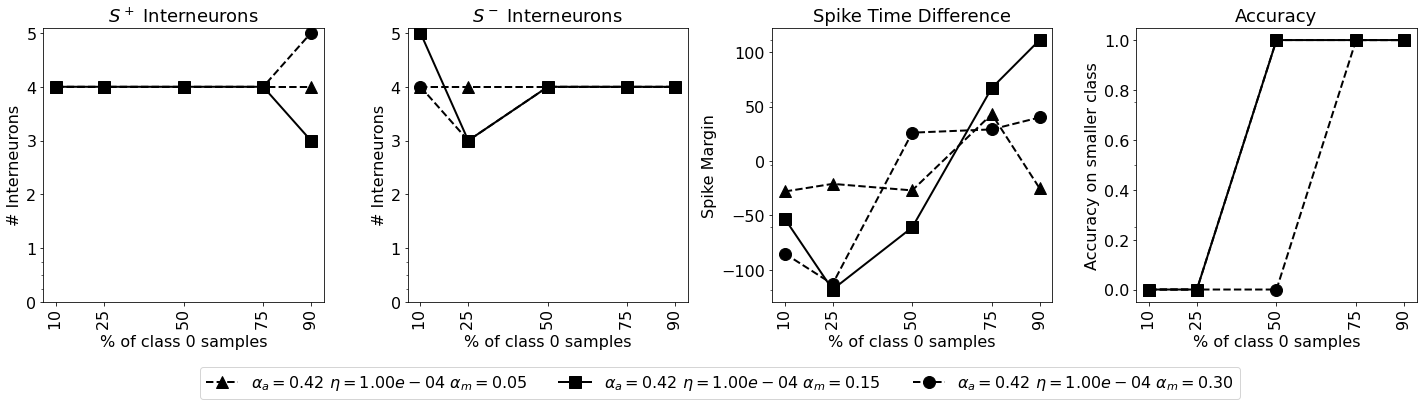

In [7]:
pos_neuron_dict = {k: [] for k in margin_factor_legends}
neg_neuron_dict = {k: [] for k in margin_factor_legends}
spk_diff_dict = {k: [] for k in margin_factor_legends}
acc_dict = {k: [] for k in margin_factor_legends}

hparams_dict['alpha_a'] = alpha_a
hparams_dict['lr'] = lr

fig_title = alpha_a_label + lr_label

for k, alpha_M in zip(margin_factor_legends, margin_value_factors):
    hparams_dict['alpha_m'] = alpha_M
    for pos_samples in num_positive_samples:
        train_spikes, test_spikes, train_labels, test_labels = create_data(pos_samples, total_samples-pos_samples, test_size, device)
        net = OverallSNN(hparams_dict)
        accuracy, avg_spk_diff = net.fit(train_spikes, train_labels, test_spikes, test_labels)
        acc_dict[k].append(accuracy)
        spk_diff_dict[k].append(avg_spk_diff)
        pos_neuron_dict[k].append(net.c1)
        neg_neuron_dict[k].append(net.c0)

        del net, train_spikes, train_labels, test_spikes, test_labels

plot_(pos_neuron_dict, neg_neuron_dict, spk_diff_dict, acc_dict, fig_title)